<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Earthquake physics</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)"> Dynamic Rupture in 2D </div>
        </div>
    </div>
</div>

# Description

(modified from 'rupture 2D' by Mitchell Williams and Kenneth Duru)

This notebook simulates  dynamic earthquake ruptures and elastic wave propagation in two space dimensions (2D). Spontaneously propagating shear ruptures on a frictional interface in an elastic solid is a useful idealization of natural earthquakes. The conditions relating slip-rate and fault strength are often expressed as nonlinear friction laws.

--------------------------------------------------------------------

### The elastic wave equation

Consider two elastic solids separated by a fault at the interface $x = 0$. In each elastic solid, wave motion is described by the elastic wave equation, in velocity-stress formulation: 
<br/><br/> 
\begin{align}
{\rho} {\partial_t v_i} = {\frac{ \partial \sigma_{ij}}{\partial x_j},  \quad}  {\quad}   S_{klij}{\partial_t \sigma_{ij}} = \frac{1}{2}  \cdot (\frac{\partial v_k}{\partial x_l} + \frac{\partial v_l}{\partial x_k}), \quad i, j = 1, 2,
\end{align}
<br/> <br/>
 with particle velocities ${v_i}$, stress tensor ${\sigma_{ij} }$, compliance tensor $S_{klij}$, and density ${\rho}$.
<br/><br/>


On the fault there is the velocity vector $\left(v_{n}, v_{m}\right)=\left(v_{x}, v_{y}\right)$, and the traction vector $\left(T_{n}, T_{m}\right)=\left(\sigma_{xx}, \sigma_{xy}\right)$, where $v_{n}$, $T_{n}$ are the normal components and $v_{m}$, $T_{m}$ being the shear components on the  interface. Denoting the fields in the positive and the negative parts of the fault with the superscripts $\pm$, we introduce the jumps in particle velocities by $\lbrack{v_j}\rbrack = {v_j}^{+}-{v_j}^{-}$, with $j = m, n$, and  the total traction by $T_j = T_{0j} + \Delta{T_j}$, where $T_{0j}$ are the initial background tractions and $\Delta{T_j}$ are the traction changes on the fault. The conditions on the fault connecting the two elastic solids are
<br/><br/> 
\begin{align}
\text{force balance}&: \quad T_{j}^{+} = T_{j}^{-} = T_{j}, \quad j = m, n, \\
\text{no opening}&: \quad \lbrack{v_n}\rbrack = 0,\\
\text{friction laws}&: \quad T_m = \sigma_n\frac{f(V, \theta)}{V}\lbrack{v_m}\rbrack, \quad V = \left|\lbrack{v_m}\rbrack\right|.
\end{align}
<br/> <br/>
 Here $\sigma_n > 0$ is the compressive normal stress and $ f(V, \theta) \ge 0 $ is the nonlinear fricition coefficient relating to the fault's shear strength, $\tau = |T_m| > 0$, and will be described  in more detail below.
<br/><br/>

-------------------------------------------------------------


### How to use the notebook

In the parameter window you can modulate the material properties, run time, domain size, and CFL criterion. In addition, you can choose rate and state friction or slip weakening friction, notice the differences that occur with this choice. In the Calculations and plotting cell the resulting on fault tractions and slip velocities are solved for in the RK4_2D.elastic_RK4_2D function, which also calls on the other associated functions. The bottom cell contains 5 output plots of the rupture behavior. 


The plot that is observed immediately under this cell is the particle velocity plotted in the entire domain. The fault runs vertically through the center of the model and is marked by a vertical line. When this animation finishes the seismograms of the earthquake pop up under this. In the last cell there are three plots that come from the data generated in the previous cell. These three plots show the on fault slip, slip rate, and tractions as they evlove through time. Lastly there is a plot that shows the slip rate on the fault through time.
 


In [8]:
# Import necessary routines
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import RK4_2D

#plt.switch_backend("TkAgg")          # plots in external window
plt.switch_backend("nbagg")           # plots within this notebook

In order to show a less time consuming solution the spatial and temporal resolution has been decreased. In the case you would like to increase it, you can modify the grid points in x and y (mantaining their proportions), the snapshot frequency and the fracture mode. 

In [9]:
# Parameter cell
Lx = 10.0     # length of the domain (x-axis)
Ly = 20.0     # width of the domain (y-axis)

#change these values to get a higher spatial resolution 
nx = 50       # grid points in x
ny = 100      # grid points in y
tend = 0.98*3.464      # final time
CFL = 0.5

#change these values to get a higher temporal resolution
isnap = 5     # snapshot frequency
order = 4     # spatial order of accuracy (2,4,6)

nf = 5        # number of fields

cs_l = 3.464    # shear wave speed
cp_l = 6.0      # compresional wave speed
rho_l = 2.6702  # density

cs_r = 3.464    # shear wave speed
cp_r = 6.0      # compresional wave speed
rho_r = 2.6702  # density

# Bi-material:
#cs_r = 2.0      # shear wave speed
#cp_r = 4.0      # compresional wave speed
#rho_r = 2.6     # density

dx = Lx/nx    # spatial step in x
dy = Ly/ny    # spatial step in y

print('your x-axis resolution is '+str(dx)+' km')
print('your y-axis resolution is '+str(dy)+' km')

your x-axis resolution is 0.2 km
your y-axis resolution is 0.2 km


In [10]:
# Friction and Fracture parameter cell 

# Friction type
fric_law = 'SW'   #RS:Rate-and-state OR SW:Linear slip-weakening

# Fracture mode
mode = 'III'   #  'II' or 'III'

cs = np.max([cs_l, cs_r])
cp = np.max([cp_l, cp_r])

# Set mode info
# Mode II crack: In-plane shear
if mode == 'II':
    nf = 5        # number of fields [vx, vy, sxx, syy, sxy] 
    dt = CFL/np.sqrt(cp**2 + cs**2)*dx    # Time step

# Mode III crack: out-of-plane (anti-plane) shear    
if mode == 'III':
    nf = 3        # number of fields  [vz, sxz, sxy] 
    dt = dx*CFL/cs    # Time step

nt = np.int(np.round(tend/dt)) # number of time steps

# To test your own friction parameters change the varible 'user_params' from 'default' to 'edit'
# then reasign your own values to the following variables 
user_params = 'default'

Tau_0_user = np.ones((ny, 1))                           # shear stress 
alp_s_user = np.ones((ny, 1))                           # stastic friction
alp_d_user = np.ones((ny, 1))                           # dynamic friction
D_c_user = np.ones((ny, 1))                             # critical slip
sigma_n_user = -np.ones((ny, 1))                        # normal stress 
L0_user = np.ones((ny, 1))                              # state evolution distance
f0_user = np.ones((ny, 1))                              # referance friction coeff
a_user = np.ones((ny, 1))                               # direct effect 
b_user = np.ones((ny, 1))                               # evolution parameter 
V0_user = np.ones((ny, 1))                              # reference slip rate

In [11]:
# Initializaion cell 
# Do not change! ! !

# Friction condition
Y_fault =np.zeros((ny, 1)) 
Y0 = 10
slip = np.zeros((ny, 1))
psi = np.zeros((ny, 1))
FaultOutput = np.zeros((ny, nt, 6)) # c
FaultOutput0 = np.zeros((ny, 6))

for j in range(0, ny):
        #Y_fault[j, 0] = j*dy
        
        if np.abs(j*dy-Y0) <= 1.5:
            Y_fault[j, 0] = 1.0
if fric_law not in ('SW', 'RS'):
    # Choose friction law: fric_law
    # Slip-weakening (SW)
    # Rate-and-state friction law (RS)
    
    print('friction law not implemented. choose fric_law = SW or fric_law = RS')
    exit(-1)
    
if user_params not in ('edit', 'default'):

    print('friction law not implemented. choose user_params = edit or fric_law = default')
    exit(-1)
    
if user_params == 'edit':
    Tau_0 = Tau_0_user                          # shear stress 
    alp_s = alp_s_user                           # stastic friction
    alp_d = alp_d_user                         # dynamic friction
    D_c = D_c_user                             # critical slip
    sigma_n = sigma_n_user                        # normal stress 
    L0 = L0_user                               # state evolution distance
    f0 = f0_user                             # referance friction coeff
    a = a_user                              # direct effect 
    b = b_user                              # evolution parameter 
    V0 = V0_user                             # reference slip rate
    
if fric_law  in ('SW'):
     alpha = np.ones((ny, 1))*1e1000000                      # initial friction coefficient
     slip = np.zeros((ny, 1))                        # initial slip (in m)
     slip_new = np.zeros((ny, 1))
     #Tau_0 = np.ones((ny, 1))*(70+11.6*(np.exp(-(Y_fault-7.0)**2/(2*9))))               # initial load (81.24 in MPa), slight increase will unlock the fault
     
     if user_params == 'default':
        Tau_0 = np.ones((ny, 1))*(70+11.6*Y_fault)   
        alp_s = np.ones((ny, 1))*0.677                          # stastic friction
        alp_d = np.ones((ny, 1))*0.525                          # dynamic friction
        D_c = np.ones((ny, 1))*0.4                              # critical slip
        sigma_n = -np.ones((ny, 1))*120.0                        # normal stress 
     
        
     # These are not needed for the slip weakening case   
     psi = np.ones((ny, 1))*0.0                         # initial condition for the state variable in friction law
     psi_new = np.ones((ny, 1))*0.0
     L0 = np.ones((ny, 1))*1.0                               # state evolution distance
     f0 = np.ones((ny, 1))*1.0                               # referance friction coeff
     a = np.ones((ny, 1))*1.0                                # direct effect 
     b = np.ones((ny, 1))*1.0                                # evolution parameter 
     V0 = np.ones((ny, 1))*1.0                               # reference slip rate
        
     FaultOutput[:, 0, 2] = sigma_n[:,0]   
     FaultOutput[:, 0, 3] = Tau_0[:,0] 
     FaultOutput[:, 0, 4] = slip[:,0] 
     FaultOutput[:, 0, 5] = psi[:,0]   
    
if fric_law  in ('RS'):
    alpha = np.ones((ny, 1))*1e1000000                      # initial friction coefficient                                                                                   
    slip = np.ones((ny, 1))*0.0                         # initial slip (in m) 
    slip_new = np.zeros((ny, 1))
    #Tau_0 = np.ones((ny, 1))*81.24+0.1*0.36                 # initial load (81.24 in MPa), slight increase will unlock the fault   
    psi = np.ones((ny, 1))*0.4367                      # initial condition for the state variable in friction law
    psi_new = np.ones((ny, 1))*0.0
    
    if user_params == 'default':
        sigma_n = -np.ones((ny, 1))*120.0                        # background normal stress 
        Tau_0 = np.ones((ny, 1))*75 #-2*0.2429*sigma_n*Y_fault
        L0 = np.ones((ny, 1))*0.02                              # state evolution distance
        f0 = np.ones((ny, 1))*0.6                               # referance friction coeff
        a = np.ones((ny, 1))*0.008                              # direct effect 
        b = np.ones((ny, 1))*0.012                              # evolution parameter 
        V0 = np.ones((ny, 1))*1.0e-6                            # reference slip rate
    
    
    Vin = np.ones((ny, 1))*2.0e-12 
    theta = L0/V0*np.exp(((a*np.log(2.0*np.sinh(75/(a*120)))-f0-a*np.log(Vin/V0))/b))
    psi[:,0] = f0[:,0] + b[:,0]*np.log(V0[:,0]/L0[:,0]*theta[:,0])
                          
    
        
        

     # These are not needed for the rate and state case   
    alp_s = np.ones((ny, 1))*1.0                             # stastic friction
    alp_d = np.ones((ny, 1))*1.0                             # dynamic friction
    D_c = np.ones((ny, 1))*1.0                               # critical slip
        
    FaultOutput[:, 0, 2] = sigma_n[:,0]  
    FaultOutput[:, 0, 3] = Tau_0[:,0]
    FaultOutput[:, 0, 4] = slip[:,0]
    FaultOutput[:, 0, 5] = psi[:,0] 
       
friction_parameters = np.zeros((12, ny))    
#friction_parameters = [alpha, alpha, Tau_0, L0, f0, a, b, V0, sigma_n, alp_s, alp_d, D_c]    
#                        0         1      2     3   4  5  6   7    8       9      10  11
for j in range(0, ny):
        friction_parameters[0, j] = alpha[j, 0]
        friction_parameters[1, j] = alpha[j, 0]
        friction_parameters[2, j] = Tau_0[j, 0]
        friction_parameters[3, j] = L0[j, 0]
        friction_parameters[4, j] = f0[j, 0]
        friction_parameters[5, j] = a[j, 0]
        
        
        friction_parameters[6, j] = b[j, 0]
        friction_parameters[7, j] = V0[j, 0]
        friction_parameters[8, j] = sigma_n[j, 0]
        friction_parameters[9, j] = alp_s[j, 0]
        friction_parameters[10, j] = alp_d[j, 0]
        friction_parameters[11, j] = D_c[j, 0]
# end friction condition

# source parameters
x0 = -15.0        # [km]
y0 = 7.5         # [km]
t0 = 0.0         # [s]
T =  0.1         # [s]
M0 = 00.0      # [MPa]
M = [0, 0, 1., 1., 0]
source_type = 'Gaussian' # 'Gaussian', 'Brune'
source_parameter = [x0, y0, t0, T, M0, source_type, M]



# extract Lame parameters
mu_l = rho_l*cs_l**2
Lambda_l = rho_l*cp_l**2-2.0*mu_l

mu_r = rho_r*cs_r**2
Lambda_r = rho_r*cp_r**2-2.0*mu_r

# Model type, available are "homogeneous", "random":
model_type = "homogeneous"

# Initialize velocity model
Mat_l = np.zeros((nx, ny, 3))

Mat_r = np.zeros((nx, ny, 3))

if model_type == "homogeneous":
    Mat_l[:,:,0] += rho_l
    Mat_l[:,:,1] += Lambda_l
    Mat_l[:,:,2] += mu_l
    
    Mat_r[:,:,0] += rho_r
    Mat_r[:,:,1] += Lambda_r
    Mat_r[:,:,2] += mu_r

elif model_type == "random":
    pert = 0.4
    
    rho_pert = np.zeros((nx+nx-1, ny))
    mu_pert = np.zeros((nx+nx-1, ny))
    lambda_pert = np.zeros((nx+nx-1, ny))
    
    
    rho_pert = 2.0 * (np.random.rand(nx+nx-1, ny) - 0.5) * pert
    mu_pert = 2.0 * (np.random.rand(nx+nx-1, ny) - 0.5) * pert
    lambda_pert = 2.0 * (np.random.rand(nx+nx-1, ny) - 0.5) * pert 
    
    
    r_rho_l = rho_pert[0:nx, :]
    r_mu_l =  mu_pert[0:nx, :]
    r_lambda_l =  lambda_pert[0:nx, :]
    
    
    
    Mat_l[:,:,0] += rho_l*(1.0 + r_rho_l)
    Mat_l[:,:,1] += Lambda_l*(1.0 + r_lambda_l)
    Mat_l[:,:,2] += mu_l*(1.0 + r_mu_l)
    
    
    r_rho_r = rho_pert[nx-1:2*(nx-1)+1, :]
    r_mu_r =  mu_pert[nx-1:2*(nx-1)+1, :]
    r_lambda_r =  lambda_pert[nx-1:2*(nx-1)+1, :]
    
    
    Mat_r[:,:,0] += rho_r*(1.0 + r_rho_r)
    Mat_r[:,:,1] += Lambda_r*(1.0 + r_lambda_r)
    Mat_r[:,:,2] += mu_r*(1.0 + r_mu_r)
    

# Initialize pressure at different time steps and the second
# derivatives in each direction
F_l = np.zeros((nx, ny, nf))
Fnew_l = np.zeros((nx, ny, nf))
X_l = np.zeros((nx, ny))
Y_l = np.zeros((nx, ny))
p_l = np.zeros((nx, ny))
v = 2.0
F_r = np.zeros((nx, ny, nf))
Fnew_r = np.zeros((nx, ny, nf))
X_r = np.zeros((nx, ny))
Y_r = np.zeros((nx, ny))
p_r = np.zeros((nx, ny))


for i in range(0, nx):
    for j in range(0, ny):
        X_l[i,j] = -Lx + i*dx
        Y_l[i,j] = j*dy
        
        X_r[i,j] = i*dx
        Y_r[i,j] = j*dy

               
# Set up seismograms     
# Receiver locations left
rx_l = np.array([0, 0])
ry_l = np.array([0, Y0])

irx_l = np.array([1, 1])
iry_l = np.array([0, 0])

for i in range(len(rx_l)):
    irx_l[i] = (np.round(rx_l[i]/dx))+(nx-1)
    iry_l[i] = (np.round(ry_l[i]/dy))

seisvx_l = np.zeros((len(irx_l), nt))
seisvy_l = np.zeros((len(irx_l), nt))

# Receiver locations right

rx_r = np.array([0, 0])
ry_r = np.array([0, Y0])

irx_r = np.array([1, 1])
iry_r = np.array([0, 0])

for i in range(len(rx_r)):
    irx_r[i] = (np.round(rx_r[i]/dx))
    iry_r[i] = (np.round(ry_r[i]/dy))

seisvx_r = np.zeros((len(irx_r), nt))
seisvy_r = np.zeros((len(irx_r), nt))

# Boundary reflection coefficients: 0<= r[j] <= 1
r_l = np.array([0.,0.,1.,0.])
r_r = np.array([0.,0.,1.,0.])

# required for seismograms
ir_l = np.arange(len(irx_l))
ir_r = np.arange(len(irx_r))

print('The final model time will be '+str(nt*dt)+' seconds')

The final model time will be 3.406466512702079 seconds


<IPython.core.display.Javascript object>


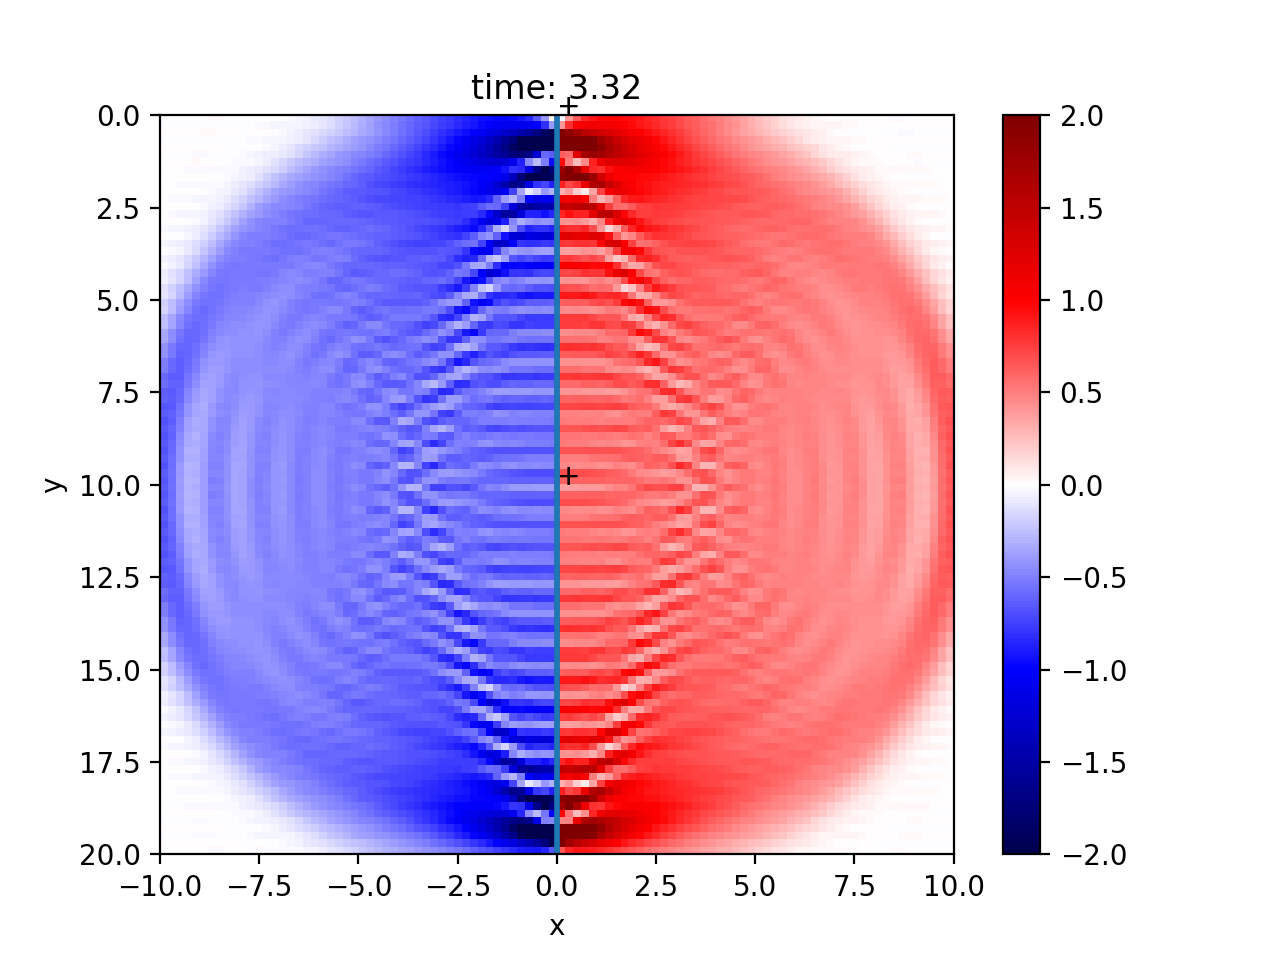

<IPython.core.display.Javascript object>


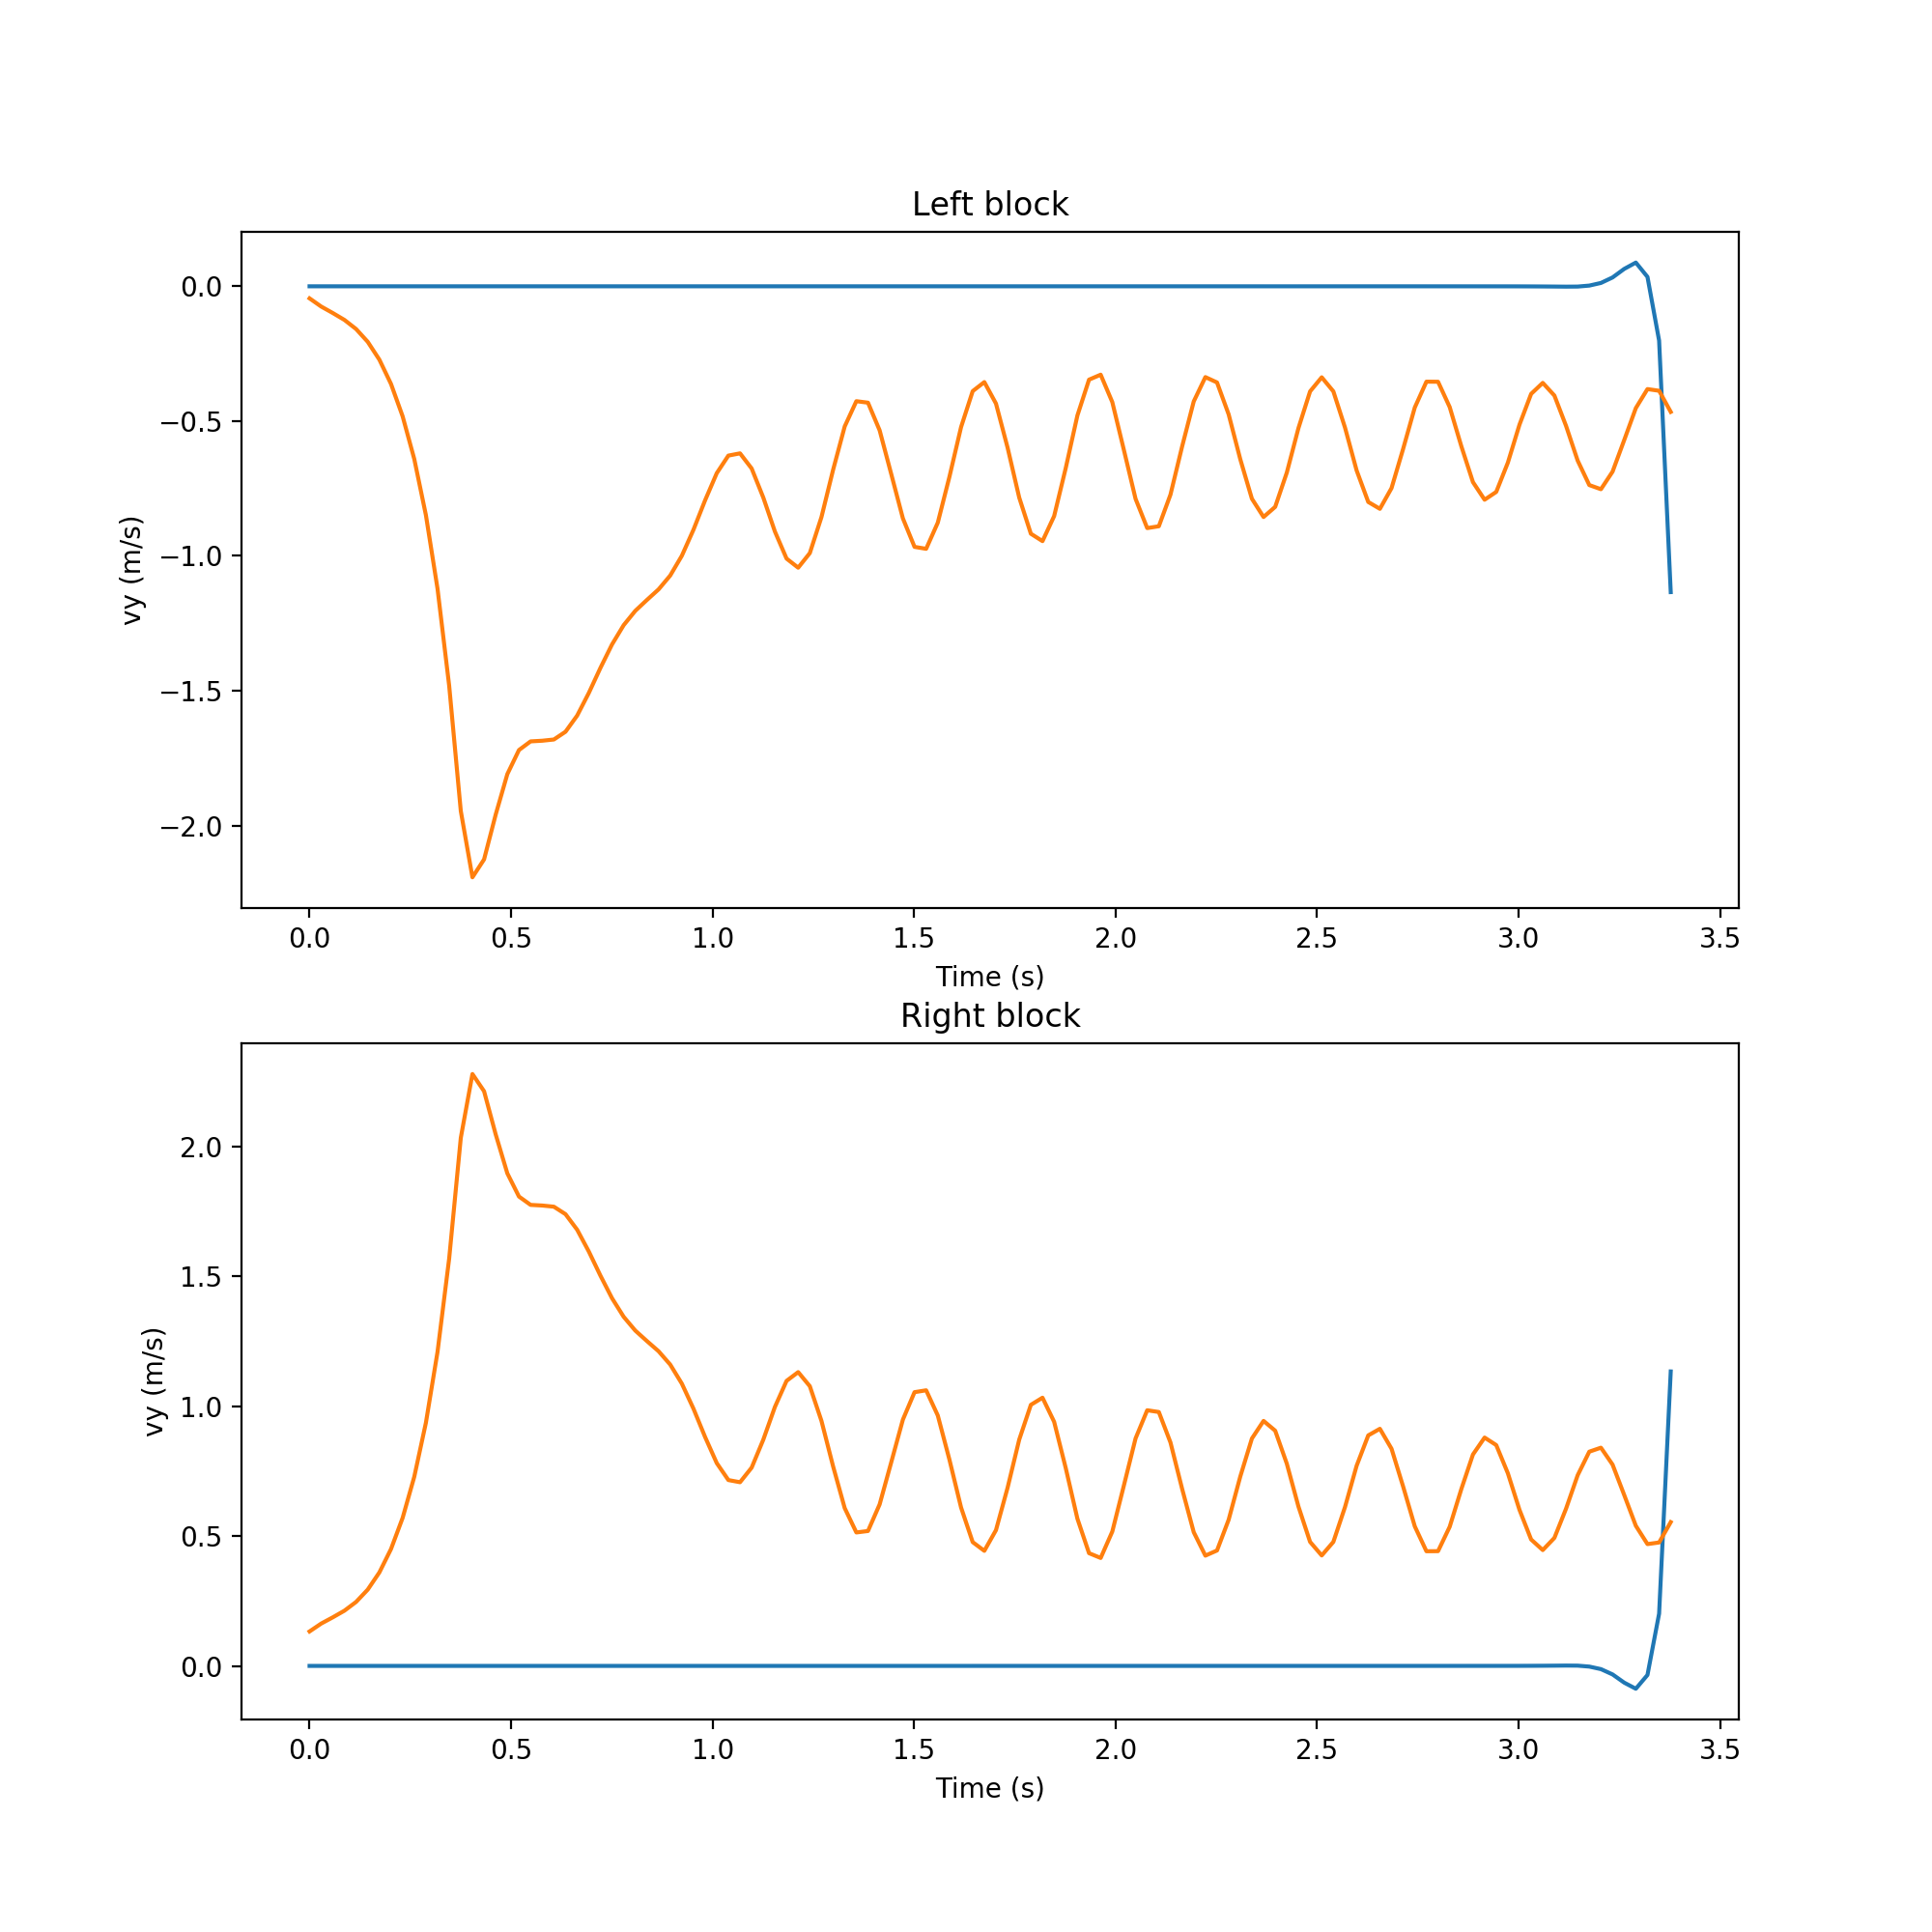

In [5]:
# Plotting cell

# create plot
image_r = plt.imshow(np.squeeze(np.append([p_l.transpose()],[p_r.transpose()],axis=2)), aspect='auto',extent=[-Lx,Lx,Ly,0]
          ,cmap = 'seismic', vmin=-v, vmax=+v, animated=True, 
          interpolation='none')

# Plot the receivers
for x, y in zip(rx_l, ry_l):
    plt.text(x, y, '+')
    
for x, y in zip(rx_r, ry_r):
    plt.text(x, y, '+')

plt.text(x0, y0, 'o')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.show()


# Time-stepping 
for it in range(nt):
    
    t = it*dt
    
    #4th order Runge-Kutta 
    RK4_2D.elastic_RK4_2D(Fnew_l, F_l, Mat_l, X_l, Y_l, t, nf, nx, ny, dx, dy, dt, order, r_l, source_parameter, Fnew_r, F_r, Mat_r, X_r, Y_r, r_r, friction_parameters, slip,  psi, slip_new, psi_new, fric_law, FaultOutput0, Y0, mode)
    
    # update fields and extract parameters
    F_l = Fnew_l
    F_r = Fnew_r
    slip = slip_new 
    psi = psi_new
    FaultOutput[:, it, :] = FaultOutput0
    if mode == 'II': 
        p_l = F_l[:,:,1]
        p_r = F_r[:,:,1]
    if mode == 'III': 
        p_l = F_l[:,:,0]
        p_r = F_r[:,:,0] 
    
    t = it*dt
    
    # Plot every isnap-th iteration
    if it % isnap == 0:                    # you can change the speed of the plot by increasing the plotting interval
        p_b = np.squeeze(np.append([p_l.transpose()],[p_r.transpose()],axis=2)) # p for both, transposed to plot
        plt.title("time: %.2f" % t)
        plt.axvline(x=0.0)
        image_r.set_data(p_b)
        plt.gcf().canvas.draw()

    
    # Save seismograms
    if mode == 'II':
        seisvy_l[ir_l, it] = F_l[irx_l[ir_l], iry_l[ir_l], 1]
        seisvy_r[ir_r, it] = F_r[irx_r[ir_r], iry_r[ir_r], 1]
        
    if mode == 'III':
        seisvy_l[ir_l, it] = F_l[irx_l[ir_l], iry_l[ir_l], 0]
        seisvy_r[ir_r, it] = F_r[irx_r[ir_r], iry_r[ir_r], 0]    

# Plot seismogram    
plt.ioff()
plt.figure(figsize=(10, 10))

plt.subplot(2,1,1)
ymax = seisvx_l.ravel().max()
time = np.arange(nt) * dt
for ir_l in range(len(seisvx_l)):
    plt.plot(time, seisvy_l[ir_l, :] + ymax * ir_l)
    plt.title('Left block')
    plt.xlabel('Time (s)')
    plt.ylabel('vy (m/s)')

plt.subplot(2,1,2)
ymax = seisvy_l.ravel().max()
for ir_l in range(len(seisvy_r)):
    plt.plot(time, seisvy_r[ir_l, :] + ymax * ir_l)
    plt.title('Right block')
    plt.xlabel('Time (s)')
    plt.ylabel('vy (m/s)')
    

plt.show()

<IPython.core.display.Javascript object>


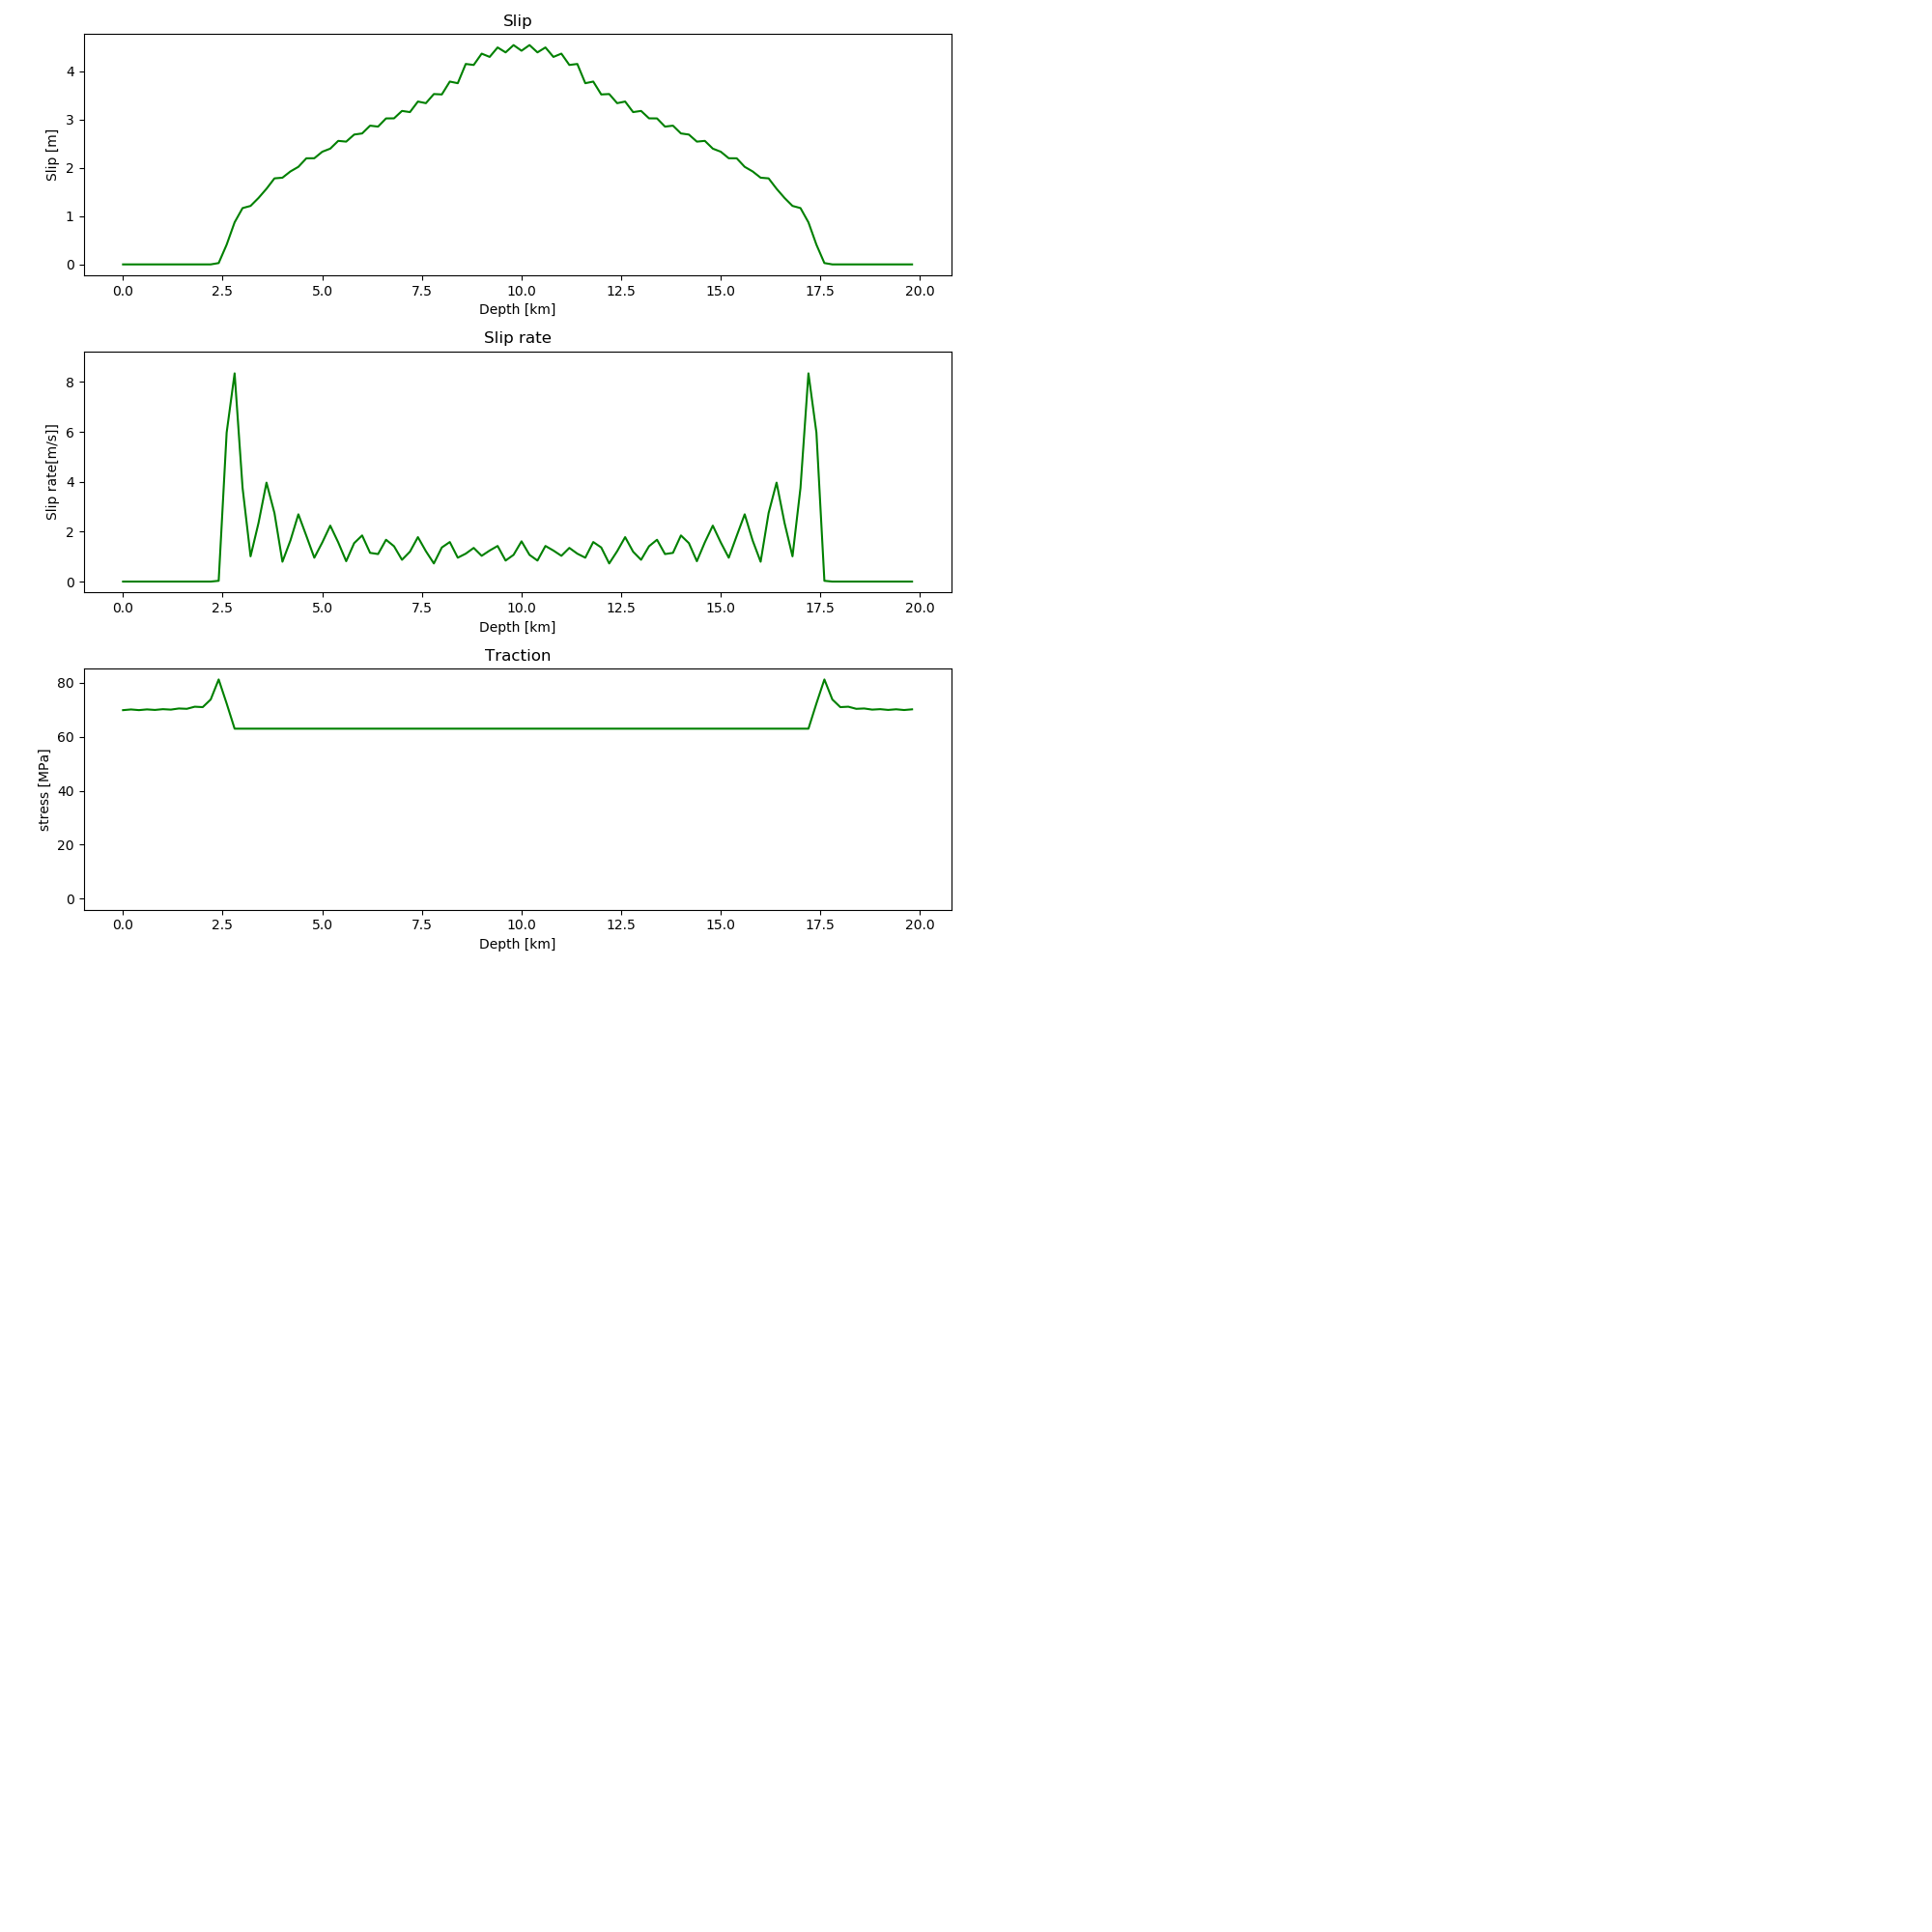

KeyboardInterrupt: 

In [6]:
# View slip, slip rate and traction. 

fig1 = plt.figure(figsize=(10,10))
ax3 = fig1.add_subplot(3,1,1)
line3 = ax3.plot(0,0,'g')
plt.title('Slip')
plt.xlabel('Depth [km]')
plt.ylabel('Slip [m]')

ax4 = fig1.add_subplot(3,1,2)
line4 = ax4.plot(0,0,'g')
plt.title('Slip rate')
plt.xlabel('Depth [km]')
plt.ylabel('Slip rate[m/s]]')

ax5 = fig1.add_subplot(3,1,3)
line5 = ax5.plot(0,0,'g')
plt.title('Traction')
plt.xlabel('Depth [km]')
plt.ylabel('stress [MPa]')

plt.tight_layout()
plt.ion()
plt.show()

y_fault = Y_l[-1,:]

for it in range(nt):
    slip_ = FaultOutput[:, it, 4]
    sliprate_ = np.sqrt(FaultOutput[:, it, 0]**2 + FaultOutput[:, it, 1]**2)
    traction_ = FaultOutput[:, it, 3]
    if it % 1 == 0: 
        
        for l in line3:
            l.remove()
            del l               
        for l in line4:
            l.remove()
            del l
        for l in line5:
            l.remove()
            del l

        # Display lines
        line3 = ax3.plot(y_fault,slip_,'g')
        line4 = ax4.plot(y_fault,sliprate_,'g')
        line5 = ax5.plot(y_fault,traction_,'g')
        plt.gcf().canvas.draw()
                   
    
plt.ioff()
plt.show()

In [7]:
#Plot time history of the slip-rate on the fault 

VT = np.zeros((nt, ny))

for it in range(nt):
    for j in range(ny):
        
        VT[it, j] = np.sqrt(FaultOutput[j, it, 0]**2 + FaultOutput[j, it, 1]**2)
        
        

v = 2.5
image_f = plt.imshow(VT, aspect='auto',extent=[0,Ly, nt*dt, 0]
          ,cmap = 'viridis', vmin=0, vmax=+v, animated=True, interpolation='none')
        
plt.title('slip-rate')
plt.colorbar()
plt.xlabel('fault [km]')
plt.ylabel('t [s]')
plt.show()

<IPython.core.display.Javascript object>